- In this notebook, we make boundary conditions using the
- LGMR as the baseline holocene

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point

In [14]:
## load modern day AMIP SSTs and SIC
## currently using the 1.9x2.5 version since that matches resolution of received icefrac data
path = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc',decode_times=False)
# amip2000 = xr.open_dataset(path + 'sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc',decode_times=False)

### Load LGMR data and regrid it

In [2]:
## THIS IS POST INFILLED DATA USED IN THIS NOTEBOOK TO MAKE THE BCs
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
LGMR_lgm_infilled_sst = xr.open_dataset(path + 'LGMR_lgm_SST_monthly_climo_merged.nc')
LGMR_holo_infilled_sst = xr.open_dataset(path + 'LGMR_holo_SST_monthly_climo_merged.nc')

LGMR_lgm_infilled_sic = xr.open_dataset(path + 'LGMR_lgm_SIC_monthly_climo_merged.nc').icefrac
# LGMR_holo_infilled_sic = xr.open_dataset(path + 'LGMR_holo_SIC_monthly_climo_merged.nc').icefrac
# JUNE 30 2022 update to holocene SIC
LGMR_holo_infilled_sic = xr.open_dataset(path + 'LGMR_holo_SIC_monthly_climo_merged_v2.nc').icefrac

## also load original data for reference
path = '/home/disk/sipn/vcooper/nobackup/lgm/LGMR/'
LGMR_lgm_original_sst = xr.open_dataset(path + 'LGMR_SST_lgm_19-23ka_ensmean.nc').sst_mon
LGMR_holo_original_sst = xr.open_dataset(path + 'LGMR_SST_holo_0-4ka_ensmean.nc').sst_mon

LGMR_lgm_original_sic = xr.open_dataset(path + 'LGMR_SIC_lgm_19-23ka_ensmean.nc').sic_mon
LGMR_holo_original_sic = xr.open_dataset(path + 'LGMR_SIC_holo_0-4ka_ensmean.nc').sic_mon

In [4]:
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = LGMR_holo_infilled_sst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         filename='bilinear_again.nc',
                         reuse_weights=True)
regridder


## LGM
LGMR_lgm_infilled_sst_regrid = regridder(LGMR_lgm_infilled_sst)
LGMR_lgm_infilled_sst_regrid = LGMR_lgm_infilled_sst_regrid.sst

LGMR_lgm_original_sst_regrid = regridder(LGMR_lgm_original_sst)


## holo
LGMR_holo_infilled_sst_regrid = regridder(LGMR_holo_infilled_sst).sst
LGMR_holo_original_sst_regrid = regridder(LGMR_holo_original_sst)


/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('nlat', 'nlon') from data variable sst_mon as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attr

In [107]:
LGMRbaseline = LGMR_holo_infilled_sst_regrid

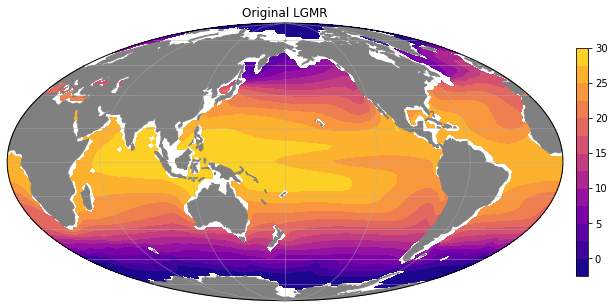

In [11]:
## Original LGMR data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_holo_original_sst_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = 'plasma',vmin=-2,vmax=32,levels=12,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Original LGMR')
plt.show()

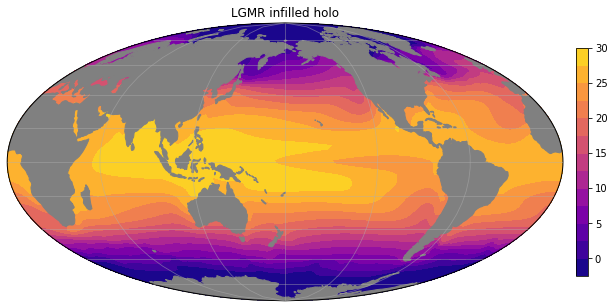

In [12]:
## regrid data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_holo_infilled_sst_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = 'plasma',vmin=-2,vmax=32,levels=12,
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('LGMR infilled holo')
plt.show()

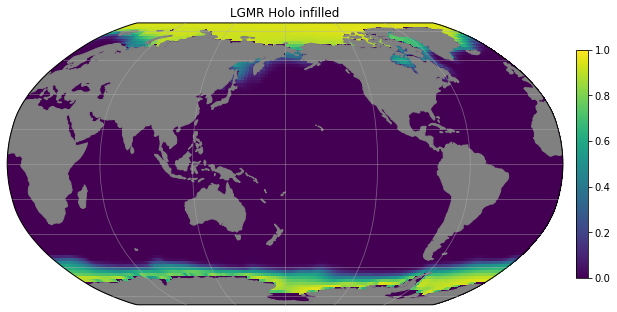

In [13]:
## Original data

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_holo_infilled_sic.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('nlon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=1,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = 'viridis',vmin=0,vmax=1,levels=10,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6,pad=0.02)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('LGMR Holo infilled')
plt.show()

# Load lgmDA

In [15]:
## Load LGM output
ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo_v2.1.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
                   tempds.set_coords(['lat','lon','month']).sst_std])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

# dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
#                    tempds.set_coords(['lat','lon','month']).sst_std])
# lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

## Load ICEFRAC
# dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
# dfile = 'lgmDA_hol_ATM_monthly_climo_v2.1.nc'
# ncf = ddir + dfile
# tempds = xr.open_dataset(ncf)
# tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
#                    tempds.set_coords(['lat','lon','month']).icefrac_std])
# holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
# holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
                   tempds.set_coords(['lat','lon','month']).icefrac_std])
lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)


## load infilled version of SST
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
lgm_sst_merged = xr.open_dataset(path + 
                                     'lgmDA_lgm_SST_monthly_climo_merged.nc')

lgm_ice_merged = xr.open_dataset(path + 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_v3.nc').set_coords(['lat','lon'])

## includes antarctic ice sheet adjustments, which probably don't matter bc land
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
holo_ice_merged = xr.open_dataset(path + 'lgmDA_hol_ICEFRAC_monthly_climo_merged_v2.nc')

In [24]:
## compute lgmDA anomaly
lgmDA_lgm_anom = lgm_sst_merged.sst - holo_sst_climo.sst.values
dsname = 'lgmDA'

In [22]:
## regrid lgmDA anomaly
## use existing bc as target grid
# newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
# newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = lgmDA_lgm_anom.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
#                          filename='bilinear_again.nc',
                         reuse_weights=False)

## LGM
lgmDA_lgm_anom_regrid = regridder(lgmDA_lgm_anom)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


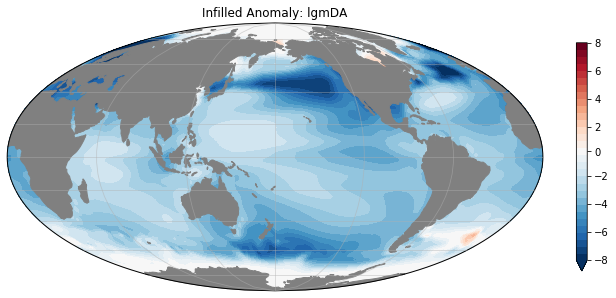

In [26]:
## anomaly
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = lgmDA_lgm_anom_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Infilled Anomaly: ' + dsname)
plt.show()

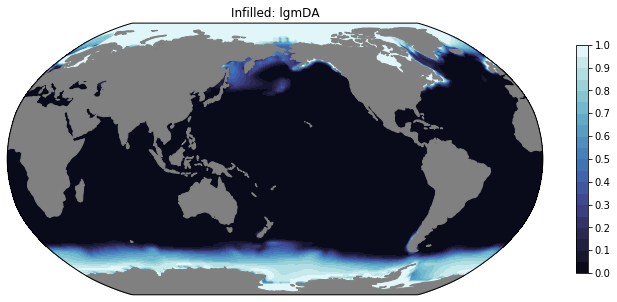

In [43]:
## SIC true
nlevs = 10*2 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = lgmDA_lgm_anom_regrid.mean(axis=0)
plot_ds = lgm_ice_merged.icefrac.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(plot_ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmo.cm.ice, vmin=0,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmo.cm.ice, vmin=0,vmax=vabs,levels=nlevs, 
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Infilled: ' + dsname)
plt.show()

# Load MARGO

In [61]:
## THIS IS POST INFILLED DATA USED IN THIS NOTEBOOK TO MAKE THE BCs
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
margo_infilled = xr.open_dataset(path + 'margo_lgm_SST_annual_merged_anoann.nc')
dsname = 'margo'

In [47]:
## This is the original data before infilling, so just for reference
import scipy.io as sio

## margo original
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/ref_files/'
margo_original = xr.open_dataset(path + 'margo_all_lgm_sst_with_errors_weighted_mean.nc')

## p2c2 versions
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/ref_files/'
mat_contents = sio.loadmat(path + 'MARGOLGMSSTs_forVince.mat')
mgo_sst = xr.DataArray(data= mat_contents['sst_anom'],
                     dims=['lat','lon'],
                     coords = {'lat': mat_contents['lat'].squeeze(),
                               'lon': mat_contents['lon'].squeeze()},
                     name = 'sst_anom')

In [53]:
data_for_regridding = margo_infilled
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

margo_infilled_regrid = regridder(margo_infilled).sst

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


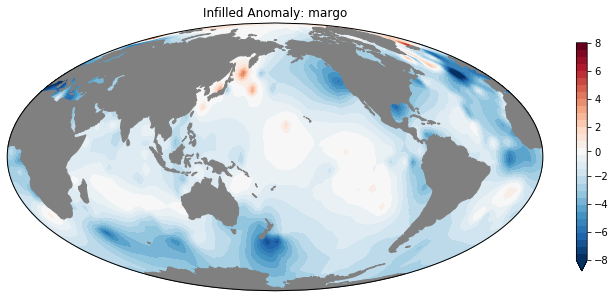

In [72]:
## anomaly
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = margo_infilled_regrid#.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Infilled Anomaly: ' + dsname)
plt.show()

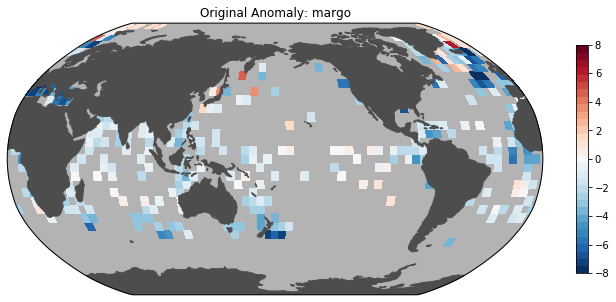

In [96]:
## anomaly
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = margo_original.anoann#.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,#extend='min',#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.3',zorder=1)
axtemp.add_feature(cfeature.OCEAN,alpha=1,zorder=0.1,color='0.7')
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
axtemp.set_global()
plt.title('Original Anomaly: ' + dsname)
plt.show()

# Load Amrhein

In [49]:
## THIS IS POST INFILLED DATA USED IN THIS NOTEBOOK TO MAKE THE BCs
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
amrheinANN_infilled = xr.open_dataset(path + 'amrhein_lgm_SST_annual_merged_anoann.nc')

In [50]:
## p2c2 versions
path = '/home/disk/atmos/vcooper/work/p2c2/lgm/ref_files/'
mat_contents = sio.loadmat(path + 'AmrheinLGMSSTs_forVince.mat')
amr_sst = xr.DataArray(data= mat_contents['sst_anom'],
                     dims=['lat','lon'],
                     coords = {'lat': mat_contents['lat'].squeeze(),
                               'lon': mat_contents['lon'].squeeze()},
                     name = 'sst_anom')

In [51]:
data_for_regridding = amrheinANN_infilled
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

amrheinANN_infilled = regridder(amrheinANN_infilled)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


# Load Annan

In [97]:
## ERSST
pislice = slice('1851-01-01','1880-12-31')
path = '~/work/p2c2/lgm/annan/'
fname = 'ersst_v5.sst.mnmean.nc'
ersst = xr.open_dataset(path + fname).sel(time=pislice).groupby('time.month').mean()

## HadISST2
fname = 'HadISST.2.2.0.0_sea_ice_concentration.nc'
hadisst2 = xr.open_dataset(path + fname).sel(time=pislice).groupby('time.month').mean()

## Annan
path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'annan_lgm_SST_annual_merged_allens.nc'
annan_ens = xr.open_dataset(path + fname)
annan = annan_ens.mean(dim='nens')

In [102]:
##  need to regrid annan SST onto 1.9x2.5
data_for_regridding = annan
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=16,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
annan_regrid = regridder(annan).drop('model').sst
annan_ens_regrid = regridder(annan_ens)#.drop('model')

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [103]:
## Regrid the ersst and hadisst data
## use existing bc as target grid

data_for_regridding = ersst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
ersst_regrid = regridder(ersst)

data_for_regridding = hadisst2
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
hadisst2_regrid = regridder(hadisst2)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


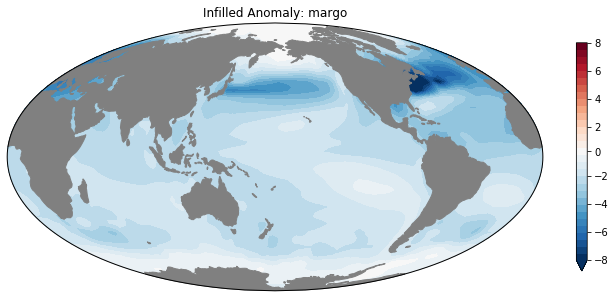

In [104]:
## anomaly
nlevs = 8*4 ## must be even
vabs = 8
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = annan_regrid#.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Infilled Anomaly: ' + dsname)
plt.show()

# Create bc by adding anomalies

In [161]:
## lgmDA
lgmDA_onLGMR = LGMRbaseline + lgmDA_lgm_anom_regrid.values

## MARGO
margo_onLGMR_ann = LGMRbaseline + margo_infilled_regrid.values

## Amrhein
# margo_onLGMR = LGMRbaseline + margo_infilled_regrid.values

## Annan
annan_onLGMR_ann = LGMRbaseline + annan_regrid.values

#### Seasonalize for test

In [216]:
## give Annan and Margo the seasonality of LGMR
## this will check whether seasonalizing by LGMR biases the data
LGMR_lgm_seasonality = (LGMR_lgm_infilled_sst_regrid - LGMR_lgm_infilled_sst_regrid.mean(dim='month'))

annan_onLGMR_seas = LGMR_lgm_seasonality + LGMRbaseline.mean(axis=0) + annan_regrid.values

margo_onLGMR_seas = LGMR_lgm_seasonality + LGMRbaseline.mean(axis=0) + margo_infilled_regrid.values

## make lgmDA have an annual version, pretending we don't know lgm seasonality
## this will check whether knowing the seasonality matters vs just adding an annual mean anom
lgmDA_onLGMR_ann = LGMRbaseline + lgmDA_lgm_anom_regrid.values.mean(axis=0)

# Organize datasets

### Check seasonality

In [213]:
## got landfrac from the CLM input data namelist
path = '/home/disk/atmos/vcooper/work/ref/'
landfrac = xr.open_dataset(path + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

In [214]:
Re = 6.37e6/1000
SAe = 4*np.pi*Re**2
SAr = landfrac.area.sum().values
print(SAr - 4*np.pi)
kmarea = (landfrac.area.where(landfrac.frac < 0.5) * SAe / SAr).values

-8.753886504564434e-12


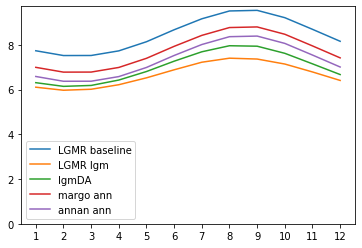

In [162]:
plt.plot(np.arange(12)+1,
         (LGMRbaseline.where(LGMRbaseline.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='LGMR baseline')

plt.plot(np.arange(12)+1,
         (LGMR_lgm_infilled_sst_regrid.where(LGMRbaseline.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='LGMR lgm')

plt.plot(np.arange(12)+1,
         (lgmDA_onLGMR.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='lgmDA')

plt.plot(np.arange(12)+1,
         (margo_onLGMR_ann.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='margo ann')

plt.plot(np.arange(12)+1,
         (annan_onLGMR_ann.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='annan ann')

plt.xticks(np.arange(12)+1)
plt.ylim(0,)
plt.legend()
plt.show()

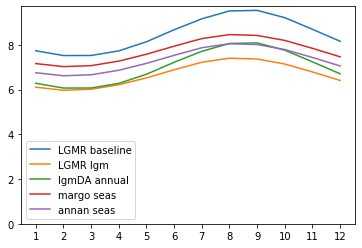

In [217]:
plt.plot(np.arange(12)+1,
         (LGMRbaseline.where(LGMRbaseline.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='LGMR baseline')

plt.plot(np.arange(12)+1,
         (LGMR_lgm_infilled_sst_regrid.where(LGMRbaseline.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='LGMR lgm')

plt.plot(np.arange(12)+1,
         (lgmDA_onLGMR_ann.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='lgmDA annual')

plt.plot(np.arange(12)+1,
         (margo_onLGMR_seas.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='margo seas')

plt.plot(np.arange(12)+1,
         (annan_onLGMR_seas.where(lgmDA_onLGMR.lat > 0) * (
             kmarea/np.nansum(kmarea))).sum(dim=['lat','lon']),
        label='annan seas')

plt.xticks(np.arange(12)+1)
plt.ylim(0,)
plt.legend()
plt.show()

# Execute Hurrell

In [235]:
## dummy code to preserve amip dataset attributes etc but use input values
LGMRholo_ice_bc_prediddle = LGMR_holo_infilled_sic.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle

## lgmDA uses its own sea ice
lgmDA_sst_bc_prediddle = lgmDA_onLGMR.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
lgmDA_ice_bc_prediddle = lgm_ice_merged.icefrac.values + amip2000.ice_cov_prediddle - amip2000.ice_cov_prediddle
lgmDAann_sst_bc_prediddle = lgmDA_onLGMR_ann.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle

## MARGO uses LGMR sea ice
margoann_sst_bc_prediddle = margo_onLGMR_ann.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
margoseas_sst_bc_prediddle = margo_onLGMR_seas.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
# margoann_ice_bc_prediddle = LGMRholo_ice_bc_prediddle

# ## Amrhein uses its own sea ice
#
#

# ## Annan uses LGMR sea ice
annanann_sst_bc_prediddle = annan_onLGMR_ann.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle
annanseas_sst_bc_prediddle = annan_onLGMR_seas.values + amip2000.SST_cpl_prediddle - amip2000.SST_cpl_prediddle

In [236]:
## This function does (what I call the) Hurrell adjustments

def data_consistency_before_bcgen(sst_prediddle_adj,sic_prediddle_adj):
    
    ## this function has the reference code from ncl script for each step
    
    # 1) If SST < -1.8 or ice frac >= 90%, SST = -1.8
    # SST = where(SST.le.-1.8, -1.8, SST)
    # SST = where(SEAICE.gt.90., -1.8, SST)

    sst_prediddle_adj = xr.where(sst_prediddle_adj < -1.8, 
                                        -1.8, sst_prediddle_adj)
    sst_prediddle_adj = xr.where(sic_prediddle_adj > 0.9, 
                                        -1.8, sst_prediddle_adj)

    # ; 2) min ice frac is 0%, max ice_frac is 100%
    # SEAICE = where(SEAICE.lt.0., 0., SEAICE)
    # SEAICE = where(SEAICE.gt.100., 100., SEAICE)
    sic_prediddle_adj = xr.where(sic_prediddle_adj < 0, 
                                        0, sic_prediddle_adj)
    sic_prediddle_adj = xr.where(sic_prediddle_adj > 1, 
                                        1, sic_prediddle_adj)


    # ; 3) Hurrell et al correction to SST (if 0.15 < ice frac < 0.9)
    # SST_max = 9.328*(0.729-(SEAICE/100.)^3)-1.8
    # SST = where((SEAICE.gt.15.).and.(SEAICE.lt.90.).and.(SST.gt.SST_max), SST_max, SST)
    SST_max = 9.328*(0.729-(sic_prediddle_adj)**3)-1.8
    sst_prediddle_adj = xr.where((sic_prediddle_adj > 0.15) & 
                                        (sic_prediddle_adj < 0.90) &
                                        (sst_prediddle_adj > SST_max), 
                                         SST_max, sst_prediddle_adj)    
    
    # ; 4) No sea ice if SST > 4.97
    # SEAICE = where(SST.gt.4.97, 0., SEAICE)
    sic_prediddle_adj = xr.where(sst_prediddle_adj > 4.97, 
                                        0, sic_prediddle_adj)
    
    # ; 5) Hurrell et al correction to ice frac (if -1.8 < SST < 4.97)
    # ice_max = 100.*(0.729-(SST+1.8)/9.328)^(1./3.)
    # SEAICE = where((SST.gt.-1.8).and.(SST.lt.4.97).and.(SEAICE.gt.ice_max), ice_max, SEAICE)
    ice_max = (0.729-(sst_prediddle_adj+1.8)/9.328)**(1./3.)
    sic_prediddle_adj = xr.where((sst_prediddle_adj > -1.8) &
                                        (sst_prediddle_adj < 4.97) & 
                                        (sic_prediddle_adj > ice_max), 
                                         ice_max, sic_prediddle_adj)
    

    # print((/"Filling in missing values in SST and SEAICE..."/))
    # poisson_grid_fill(SST, True, 1, 500, 0.01, 0.6, 0)
    # poisson_grid_fill(SEAICE, True, 1, 500, 0.01, 0.6, 0)
    ##  VTC: don't need this step because already extrapolated by regridding
    ##       but should check whether these land values are actually used?
    ##       appears they are not bc of land model.
    
    return(sst_prediddle_adj, sic_prediddle_adj)

In [237]:
## execute hurrell adj

## lgmDA ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    lgmDA_sst_bc_prediddle, lgmDA_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
lgmDA_bc_final_prediddle = bc_final_prediddle

## lgmDA annual test ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    lgmDAann_sst_bc_prediddle, lgmDA_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
lgmDAann_bc_final_prediddle = bc_final_prediddle



## margo ann ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    margoann_sst_bc_prediddle, LGMRholo_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
margoann_bc_final_prediddle = bc_final_prediddle

## margo seasonal test ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    margoseas_sst_bc_prediddle, LGMRholo_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
margoseas_bc_final_prediddle = bc_final_prediddle





## annan ann ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    annanann_sst_bc_prediddle, LGMRholo_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
annanann_bc_final_prediddle = bc_final_prediddle

## annan seasonal test ##
sst_bc_prediddle_adj, ice_bc_prediddle_adj = data_consistency_before_bcgen(
    annanseas_sst_bc_prediddle, LGMRholo_ice_bc_prediddle)
bc_final_prediddle = amip2000.copy()
bc_final_prediddle['ice_cov'] = ice_bc_prediddle_adj.astype('float32')
bc_final_prediddle['ice_cov_prediddle'] = bc_final_prediddle.ice_cov
bc_final_prediddle['SST_cpl'] = sst_bc_prediddle_adj.astype('float32')
bc_final_prediddle['SST_cpl_prediddle'] = bc_final_prediddle.SST_cpl
annanseas_bc_final_prediddle = bc_final_prediddle

## Save prediddled files

- to be ready for bcgen, a climatology needs to have an artificial dummy year before and after
- and it should only have "SST" and "ICEFRAC"
- I don't do this here-- i do it on Cheyenne after I send the file to:
- /glade/work/vcooper/p2c2/vtc_camsst/sstice_files


#### lgmDA

In [257]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDA_bc_final_prediddle_v2.nc'
# lgmDA_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDA-ann_bc_final_prediddle_v2.nc'
# lgmDAann_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving


In [258]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'lgmDA_bc_final_prediddle_v2.nc'
lgmDA_bc_final_prediddle = xr.open_dataset(savepath + fname)

savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'lgmDA-ann_bc_final_prediddle_v2.nc'
lgmDAann_bc_final_prediddle = xr.open_dataset(savepath + fname)

#### MARGO

In [259]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'margo-ann_bc_final_prediddle_v2.nc'
# margoann_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'margo-seas_bc_final_prediddle_v2.nc'
# margoseas_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving
finished saving


In [260]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'margo-ann_bc_final_prediddle_v2.nc'
margoann_bc_final_prediddle = xr.open_dataset(savepath + fname)

savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'margo-seas_bc_final_prediddle_v2.nc'
margoseas_bc_final_prediddle = xr.open_dataset(savepath + fname)

#### amrhein

In [252]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDA_bc_final_prediddle_v2.nc'
# lgmDA_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDAann_bc_final_prediddle_v2.nc'
# lgmDAann_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

In [253]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDA_bc_final_prediddle_v2.nc'
# lgmDA_bc_final_prediddle = xr.open_dataset(savepath + fname)

# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'lgmDAann_bc_final_prediddle_v2.nc'
# lgmDAann_bc_final_prediddle = xr.open_dataset(savepath + fname)

#### Annan

In [261]:
# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan-seas_bc_final_prediddle_v2.nc'
# annanseas_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

# savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
# fname = 'annan-ann_bc_final_prediddle_v2.nc'
# annanann_bc_final_prediddle.to_netcdf(savepath + fname)
# print('finished saving')

finished saving
finished saving


In [262]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan-seas_bc_final_prediddle_v2.nc'
annanseas_bc_final_prediddle = xr.open_dataset(savepath + fname)

savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'annan-ann_bc_final_prediddle_v2.nc'
annanann_bc_final_prediddle = xr.open_dataset(savepath + fname)

then send to: /glade/work/vcooper/p2c2/vtc_camsst/sstice_files/

# Check Results

In [263]:
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/'
fname = 'LGMRholo_bc_final_prediddle_v2.nc'
baseline = xr.open_dataset(savepath + fname)

### SST climo

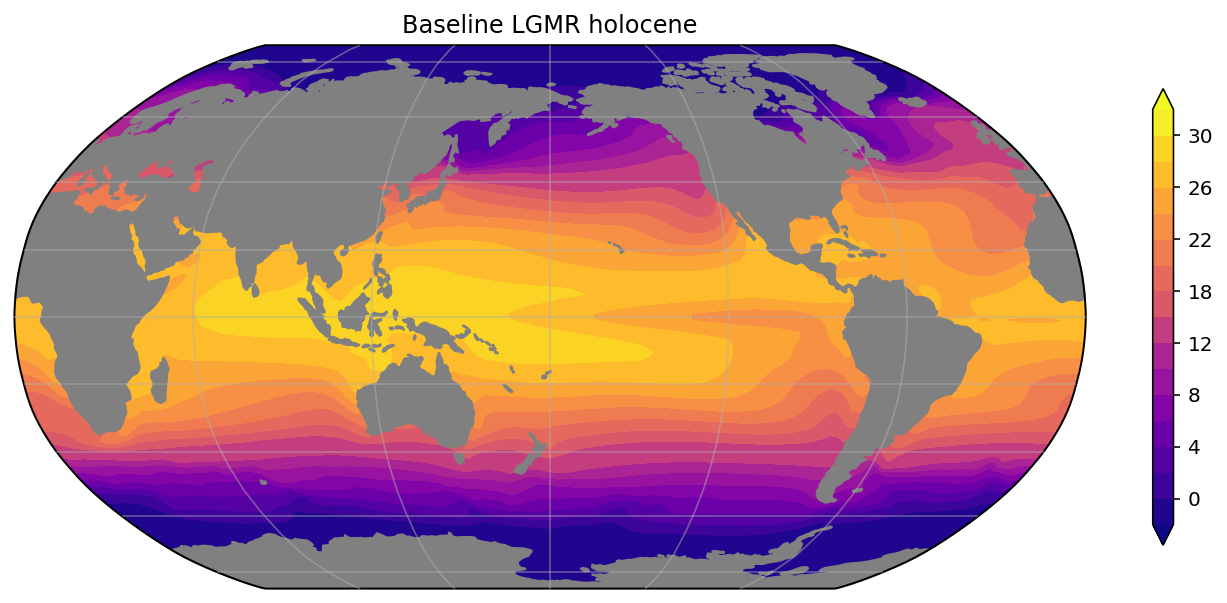

In [128]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = baseline.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Baseline LGMR holocene')
plt.show()

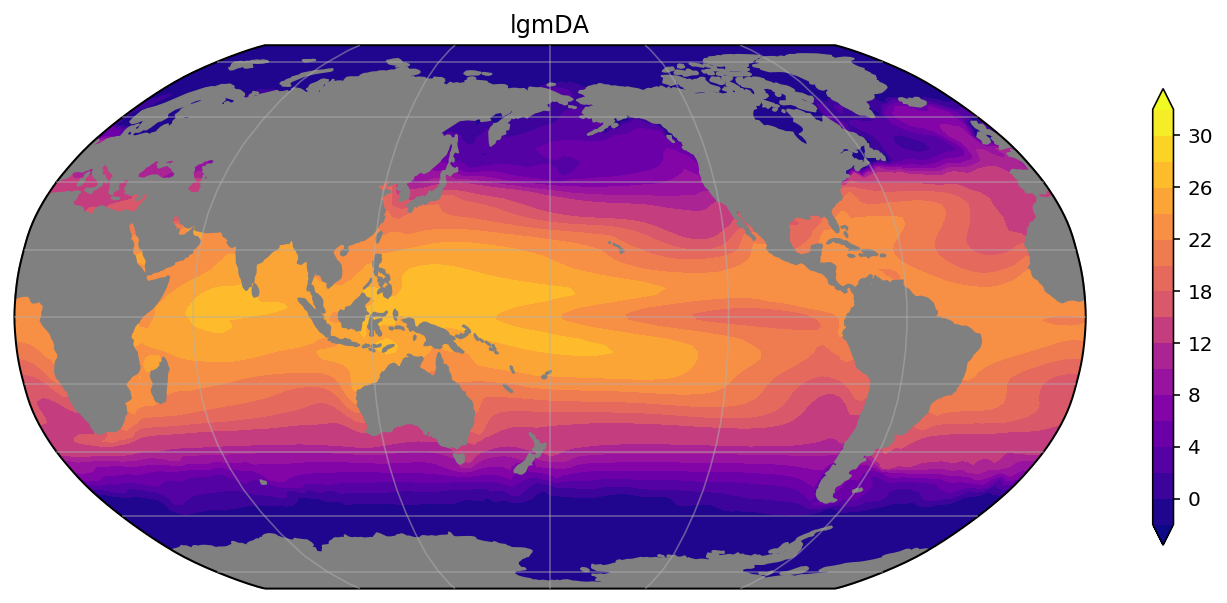

In [130]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'lgmDA'
ds = lgmDA_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname)
plt.show()

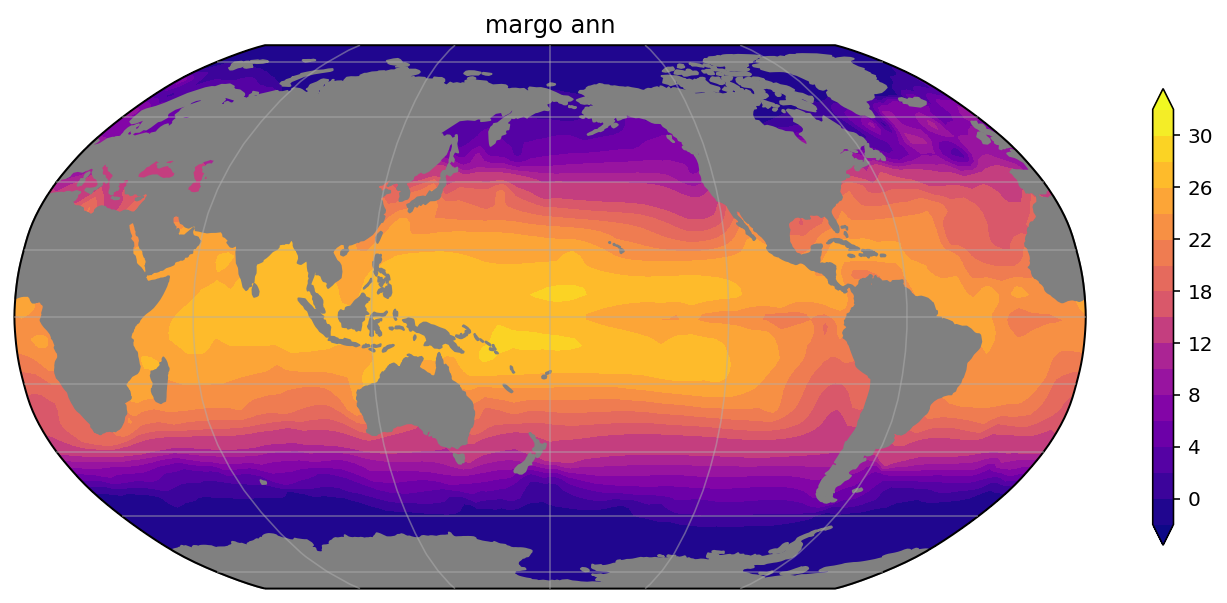

In [166]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'margo ann'
ds = margoann_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname)
plt.show()

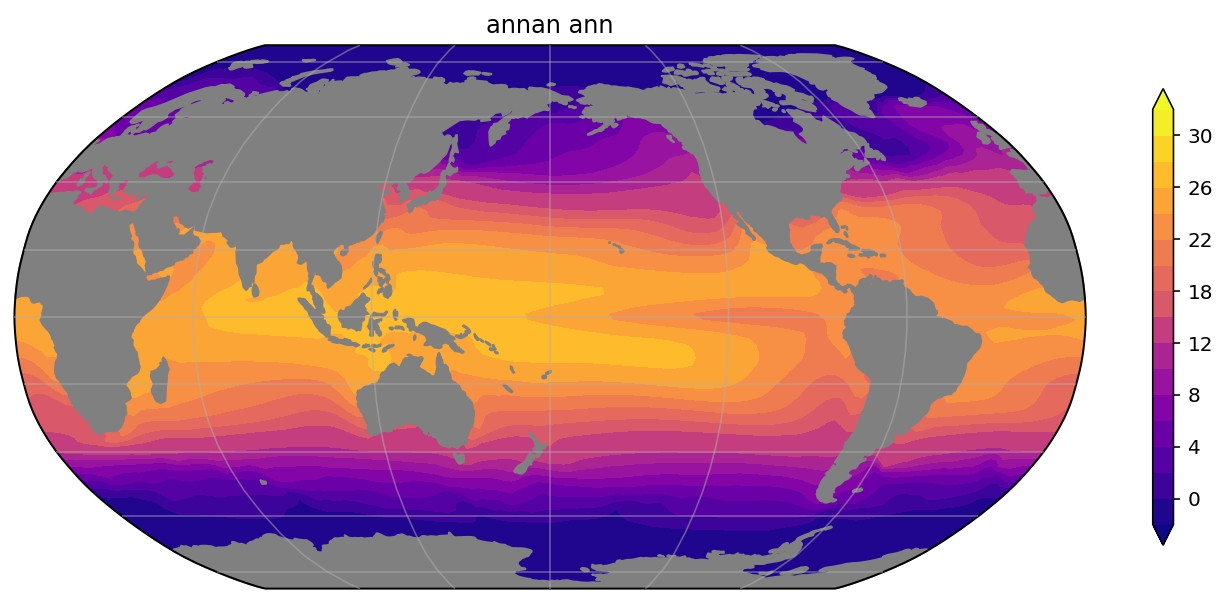

In [179]:
## infilled data climo
nlevs = 17 ## must be even
# vabs = 32
vmax=32
vmin=-2
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('plasma')#, nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'annan ann'
ds = annanann_bc_final_prediddle.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=levs, extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname)
plt.show()

## SST anomaly

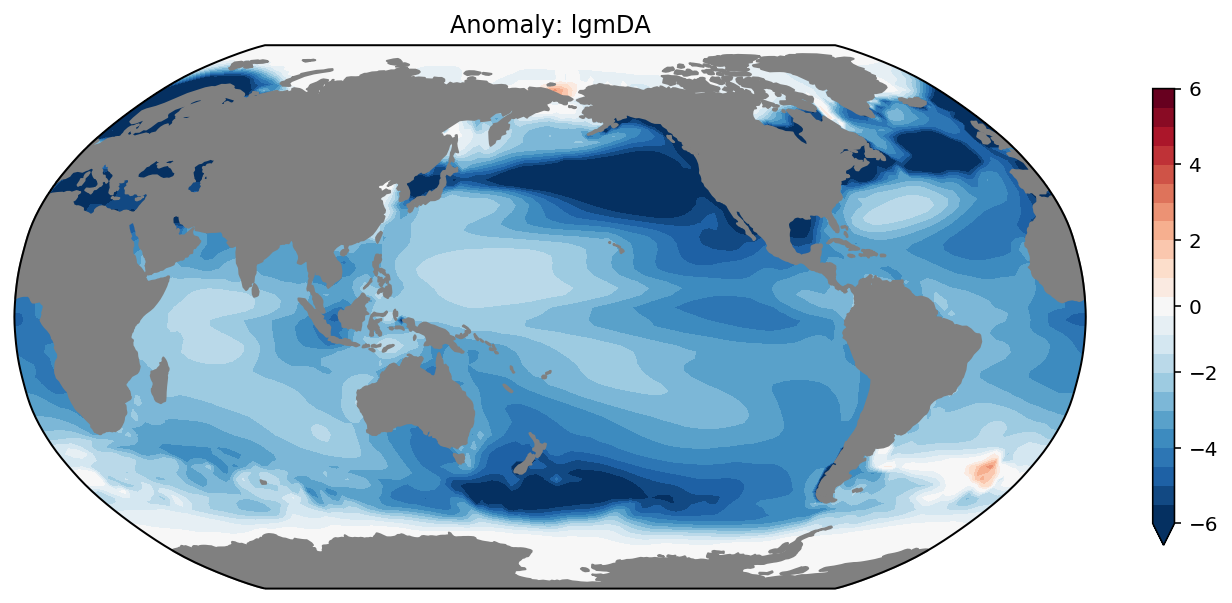

In [170]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'lgmDA'
ds = lgmDA_bc_final_prediddle.SST_cpl.mean(axis=0) - baseline.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

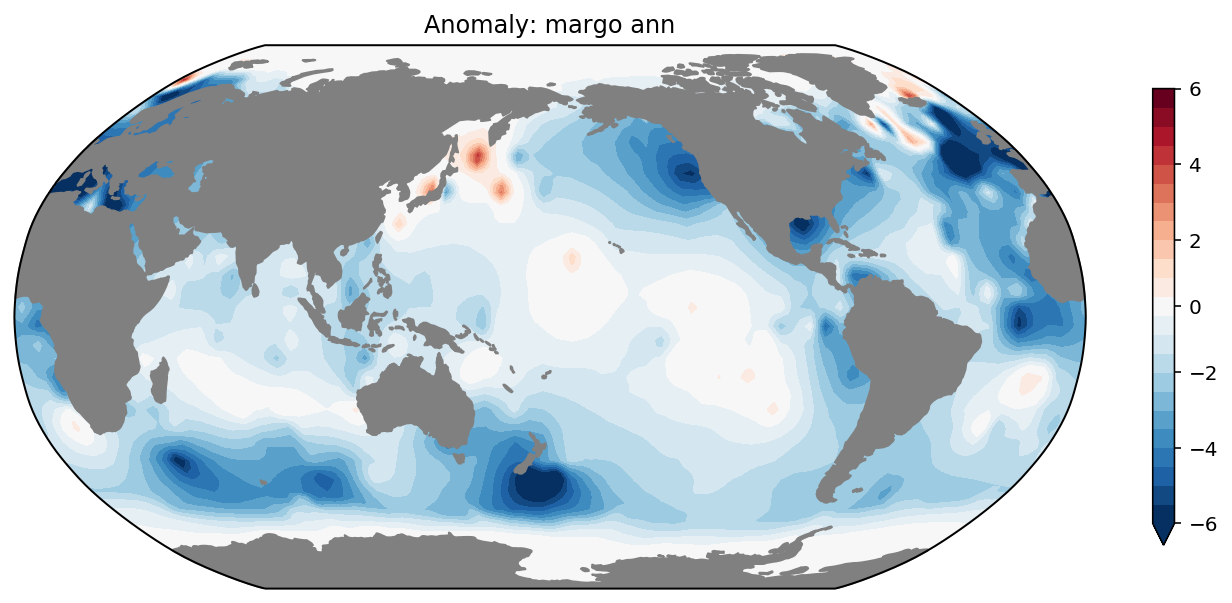

In [169]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'margo ann'
ds = margoann_bc_final_prediddle.SST_cpl.mean(axis=0) - baseline.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

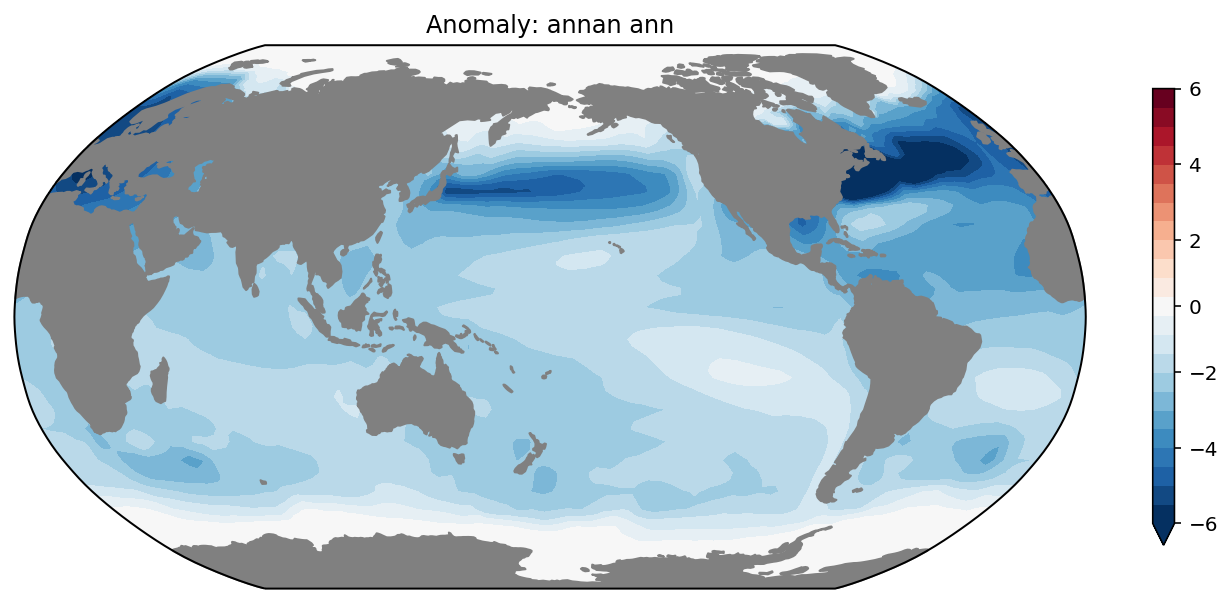

In [180]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'annan ann'
ds = annanann_bc_final_prediddle.SST_cpl.mean(axis=0) - baseline.SST_cpl.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

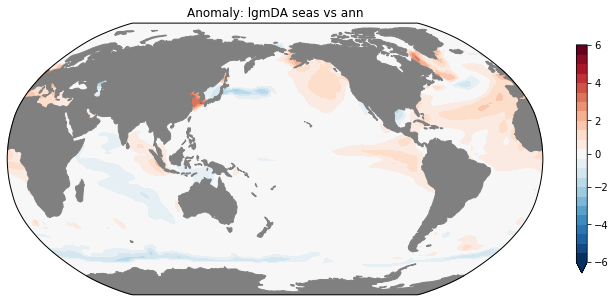

In [244]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'lgmDA seas vs ann'
# ds = annanseas_bc_final_prediddle.SST_cpl - baseline.SST_cpl
ds = lgmDA_bc_final_prediddle.SST_cpl - lgmDAann_bc_final_prediddle.SST_cpl
ds = ds[3]
# ds = ds.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

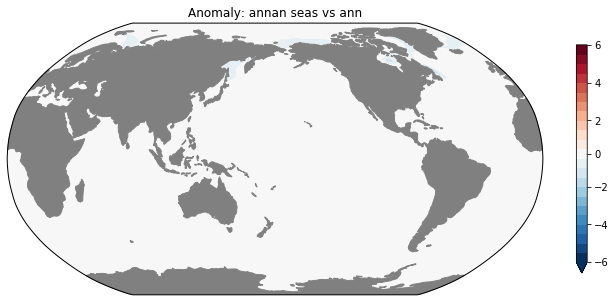

In [241]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'annan seas vs ann'
# ds = annanseas_bc_final_prediddle.SST_cpl - baseline.SST_cpl
ds = annanseas_bc_final_prediddle.SST_cpl - annanann_bc_final_prediddle.SST_cpl
ds = ds.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

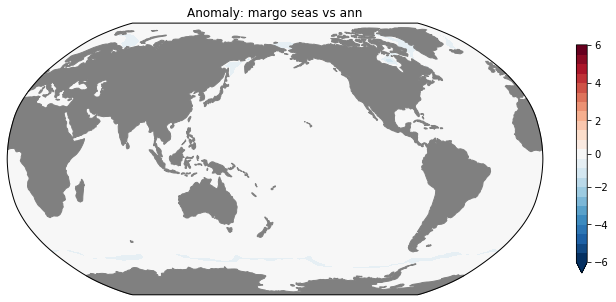

In [240]:
## infilled data anomaly
nlevs = 6*4 ## must be even
vabs = 6
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'margo seas vs ann'
# ds = annanseas_bc_final_prediddle.SST_cpl - baseline.SST_cpl
ds = margoseas_bc_final_prediddle.SST_cpl - margoann_bc_final_prediddle.SST_cpl
ds = ds.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

## Sea Ice Climo

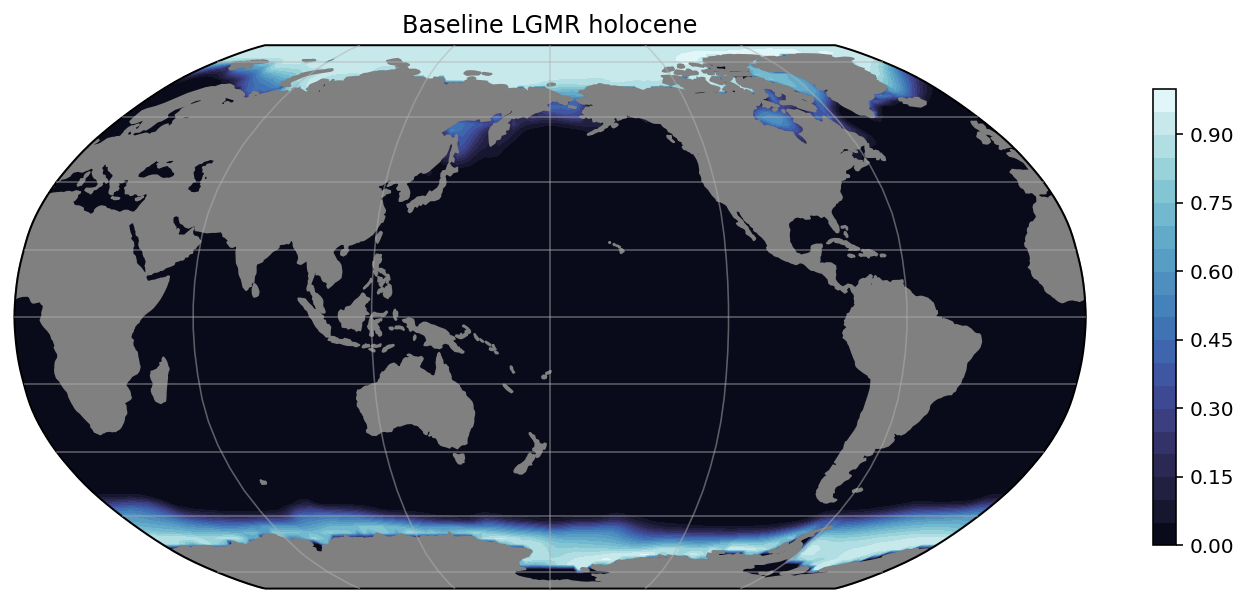

In [172]:
## infilled data climo
nlevs = 20 ## must be even
# vabs = 32
vmax=1
vmin=0
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('plasma')#, nlevs-1)
cmap = cmo.cm.ice

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = baseline.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=nlevs, #extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Baseline LGMR holocene')
plt.show()

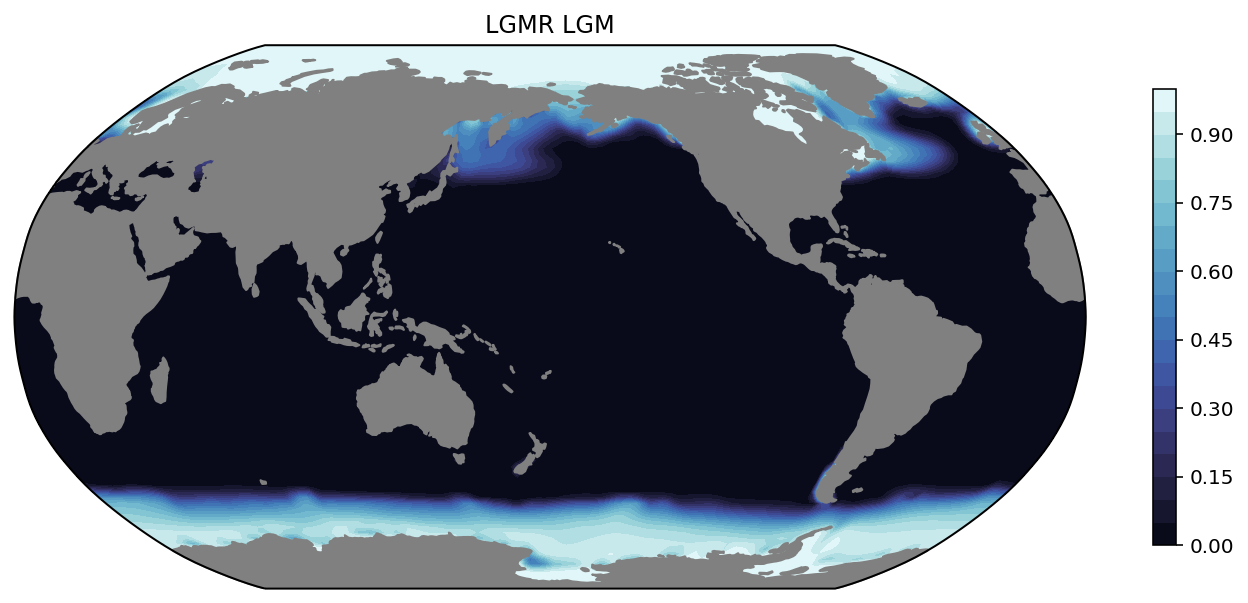

In [191]:
## infilled data climo
nlevs = 20 ## must be even
# vabs = 32
vmax=1
vmin=0
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('plasma')#, nlevs-1)
cmap = cmo.cm.ice

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = LGMR_lgm_infilled_sic.mean(dim='months')
## add cyclic point
lon_idx = ds.dims.index('nlon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=nlevs, #extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('LGMR LGM')
plt.show()

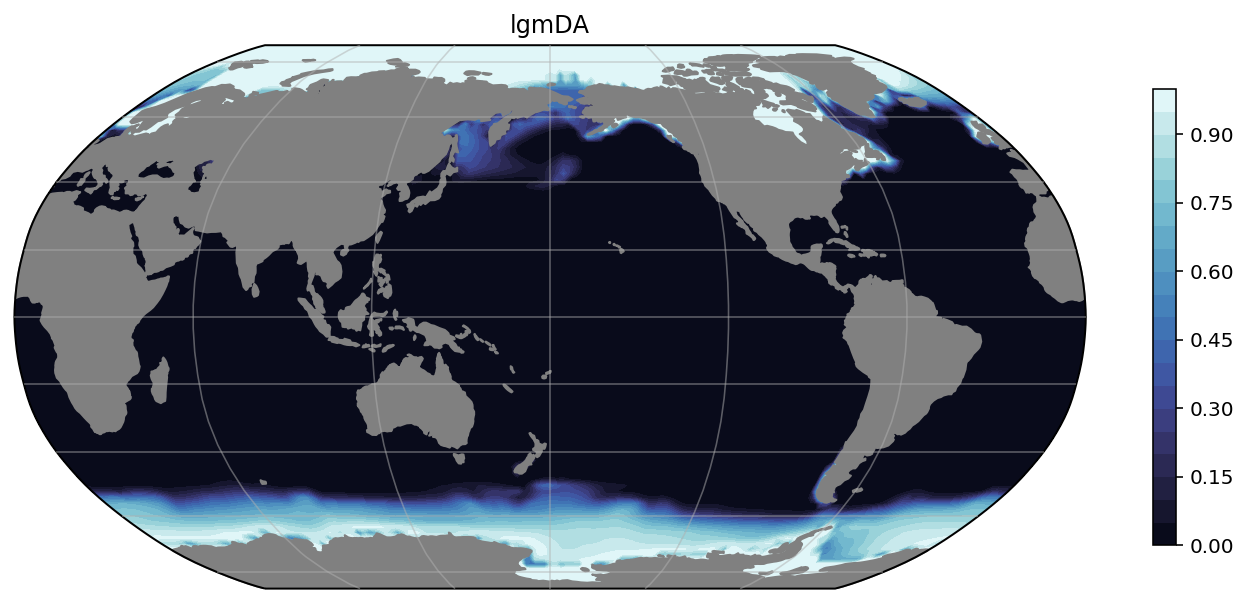

In [174]:
## infilled data climo
nlevs = 20 ## must be even
# vabs = 32
vmax=1
vmin=0
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# levs = np.delete(np.linspace(vmin,vmax,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('plasma')#, nlevs-1)
cmap = cmo.cm.ice

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72*2, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'lgmDA'
ds = lgmDA_bc_final_prediddle.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=vmin,vmax=vmax,levels=nlevs, #extend='both',
            transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,0.4))
axtemp.set_global()
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(dsname)
plt.show()

## SIC anomaly

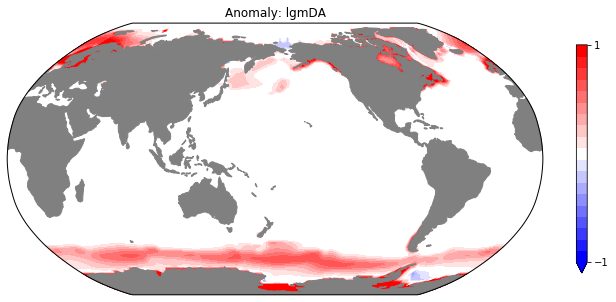

In [247]:
## infilled data anomaly
nlevs = 5*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'lgmDA'
ds = lgmDA_bc_final_prediddle.ice_cov.mean(axis=0) - baseline.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

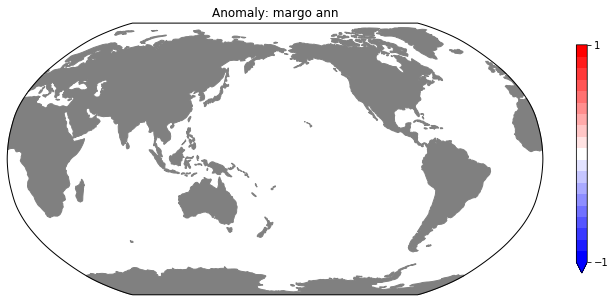

In [246]:
## infilled data anomaly
nlevs = 5*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'margo ann'
ds = margoann_bc_final_prediddle.ice_cov.mean(axis=0) - baseline.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()

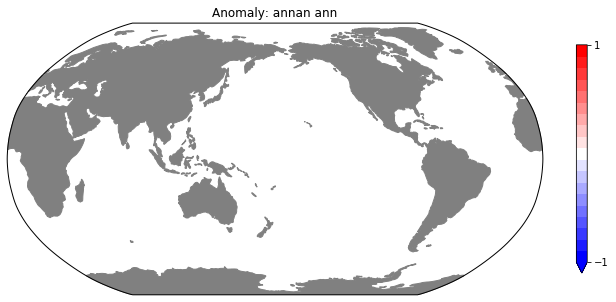

In [245]:
## infilled data anomaly
nlevs = 5*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

dsname = 'annan ann'
ds = annanann_bc_final_prediddle.ice_cov.mean(axis=0) - baseline.ice_cov.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())
plt.contourf(wrap_lon, ds.lat, wrap_ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs, extend='min',
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Anomaly: ' + dsname)
plt.show()